In [2]:
# Libraries used:
import numpy as np
import sympy
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Question 1

First I'm going to check my vdc and halton functions work by plotting 2-d halton in base 2 and 3 and checking for uniformity

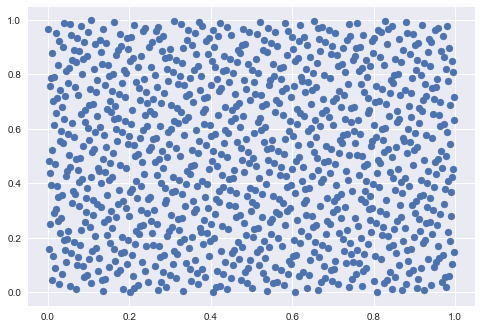

In [10]:
primes = list(sympy.primerange(2,200))

def vdc(n,b):
    digs = list(np.base_repr(n,b))
    len_digs = len(digs)
    sum = 0
    for i in range(len_digs):
        sum += int(digs[i])/b**(len_digs-i)
    return sum

def halton(n,s):
    return [vdc(n,i) for i in primes[:s]]

hal_2d_1000 = np.array([halton(n,2) for n in range(1,1001)])

plt.scatter(hal_2d_1000[:,0],hal_2d_1000[:,1])

Looks good, moving on:

In [11]:
#The following function assumes F(x) is the cdf for the uniform distribution with a = 0 and b = 1
def A_2_max(X,t):
    N = int(len(X)/t)
    V = np.array([max(X[(i*t):((i+1)*t)]) for i in range(N)])
    Z = np.sort(V) # Normally we would compute Z = F(X_i), which in this case is simply X_i
    var = [(2*(i+1)-1)*(np.log(Z[i]**t)+np.log(1-Z[N-i-1]**t)) for i in range(N)]
    return - N - (1/N)*np.sum(var)

vdc_4000 = np.array([vdc(n,2) for n in range(1,4001)])
test = A_2_max(vdc_4000,4)
print('Anderson-Darling statistic after maximum of 4-element blocks of vdc sequence:',test)

Anderson-Darling statistic after maximum of 4-element blocks of vdc sequence: 108.90248884566381


This isn't even remotely close to the values we would consider acceptable for saying this sequence resembles a uniform distribution. It makes sense though, given the strong auto-correlation present in Van der Corput sequences.

In [12]:
# This is similar to the previous function but takes in a halton sequence
def A_2_max_halton(X):
    t = X.shape[1]
    N = X.shape[0]
    V = np.array([max(X[i]) for i in range(N)])
    Z = np.sort(V)
    var = [(2*(i+1)-1)*(np.log(Z[i]**t)+np.log(1-Z[N-i-1]**t)) for i in range(N)]
    return - N - (1/N)*np.sum(var)

# PRODUCING 1000 2-DIMENSIONAL HALTON VECTORS
hal_4d_1000 = np.array([halton(n,4) for n in range(1,1001)])

test = A_2_max_halton(hal_4d_1000) 
print('Anderson-Darling statistic for 4-d halton:',test)

Anderson-Darling statistic for 4-d halton: 0.13060253203843786


This is much better. According to the paper by Stephens, rejection at the 15% significance level for Anderson Darling when F(x) is known and n>5 is 1.61, which we are well within the means of. In conclusion, the Halton sequence is a much better psuedorandom sequence for the uniform distribution than the more autocorrelated Van der Corput sequence.

Question 2

First let me implement RANDU and check for the 15 planes:

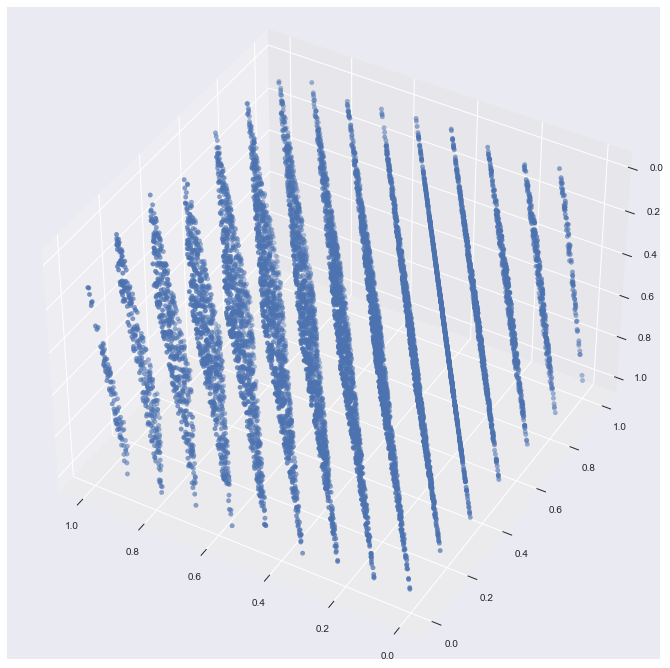

In [20]:
def RANDU(n,x_0):
    x = x_0
    array = np.zeros(n)
    for i in range(n):
        x = 65539*x % (2**31)
        array[i] = x/(2**31)
    return array

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
samples = RANDU(10000,1)
num = len(samples)
ax.scatter(samples[:num-2],samples[1:num-1],samples[2:num])
ax.view_init(-140, 60)

plt.show()

Looks good. Moving on:

In [21]:
def crit_vals(N,K,sig_values):
    p = np.zeros((N,N))
    p[0][0] = 1
    for n in range(1,N):
        p[0][n] = K**(-n)
    for n in range(1,N):
        p[n][n] = p[n-1][n-1]*(K-n)/K
    for j in tqdm(range(1,N)):
        for n in range(j+1,N):
            p[j,n] = p[j,n-1]*(j+1)/K + p[j-1][n-1]*(K-j)/K
    
    pr = np.zeros(N)
    for i in range(N):
        pr[i] = p[(N-1)-i][N-1]
        
    cvals = np.zeros((len(sig_values),2))
    s = 0
    j = 0
    for i in range(len(sig_values)):
        while s < sig_values[i]:
            s += pr[j]
            j += 1
        cvals[i] = [s,j-1]
        if s > .9999:
            break
    return cvals

# c_vals = crit_vals(20,100,[0.4,0.9,0.99])
# print(c_vals)

# This method takes a float and outputs its digits into a list like the digits() function in julia
def digit_list(n):
    return list(map(int, re.findall('\d', str(n))))

def collision_test(X):
    urns = np.zeros((10,10,10,10))
    occup = np.zeros((10,10,10,10))
    for i in range(len(X)):
        w = digit_list(X[i])[1] # we start at the second index because the first element is 0 since the number is < 1
        x = digit_list(X[i])[2]
        y = digit_list(X[i])[3]
        z = digit_list(X[i])[4]
        if urns[w][x][y][z] != 0:
            occup[w][x][y][z] += 1
        urns[w][x][y][z] += 1 
    return np.sum(occup)

K = 10000
n = 2000
x_0 = np.random.randint(2**31)
collisions = collision_test(RANDU(n,1))
print('number of collisions after {0} throws into {1} urns and initial seed {2}: {3}'.format(n,K,x_0,collisions))
c_vals = crit_vals(n,K,[0.5,0.75,0.95,0.99])
print(c_vals)

number of collisions after 2000 throws into 10000 urns and initial seed 1168533118: 192.0


100%|█████████████████████████████████████████████████████████████████████████████| 1999/1999 [00:02<00:00, 785.70it/s]

[[  0.51227544 187.        ]
 [  0.75648396 195.        ]
 [  0.95343806 207.        ]
 [  0.99003171 215.        ]]


After 2,000 throws and 10,000 partitions of varying degrees of precision, the number of collisions is more or less expected lying in between the 50% and 25% confidence levels. As we know, the pitfall of RANDU is that it cannot generate numbers that lie in between the planes generated in the above scatter plot. One thing we can try and do to capture this is throw more balls such that more collisions will occur seeing as RANDU will keep throwing balls in the same urns (the 15 planes). Here we try and throw the same number of balls as there are partitions and relax the precision:

In [22]:
def collision_test(X):
    urns = np.zeros((10,10,10))
    occup = np.zeros((10,10,10))
    for i in range(len(X)):
        w = digit_list(X[i])[1] # we start at the second index because the first element is 0 since the number is < 1
        x = digit_list(X[i])[2]
        y = digit_list(X[i])[3]
        if urns[w][x][y] != 0:
            occup[w][x][y] += 1
        urns[w][x][y] += 1 
    return np.sum(occup)

K = 1000
n = 1000
x_0 = np.random.randint(2**31)
collisions = collision_test(RANDU(n,1))
print('number of collisions after {0} throws into {1} urns and initial seed {2}: {3}'.format(n,K,x_0,collisions))
c_vals = crit_vals(n,K,[0.5,0.75,0.95,0.99])
print(c_vals)

number of collisions after 1000 throws into 1000 urns and initial seed 1615918494: 376.0


100%|██████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1560.24it/s]

[[  0.53279716 368.        ]
 [  0.7551114  374.        ]
 [  0.95577766 384.        ]
 [  0.99207159 391.        ]]


It is slightly more indicative that RANDU is suspect, giving us a critical value that lies between the 25% and 5% significance levels. Really, the perfect test would be to alter the partitions (urns) such that they would align with the planes exactly. So there would be entire diagonals of partitions that would lie along the planes of RANDU. This would cause a very high number of collisions, leading us to reject RANDU.

I'm not really sure how to implement this yet, and seeing as I am already turning this assignment in late, the explanation will have to do!